In [32]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
cnn_config = {
    "host": "kaggle-talkingdata-adtracking-fraud-detection.civd5r1fqbzl.us-east-2.rds.amazonaws.com",
    "port": "5432",
    "dbname": "kaggle",
    "user": "kurobeer",
    "password": "pass0123"
}
cnn = psycopg2.connect(**cnn_config)
cur = cnn.cursor()
cnn.get_backend_pid()

12880

In [3]:
cur.execute('select relname from pg_stat_user_tables;')
cur.fetchone()

('tab_cnt_app_channel',)

In [4]:
df = pd.read_sql(sql="SELECT * FROM tab_cnt_app_channel;", con=cnn)
df.head()

,is_test,app,channel,cnt,flg
0,0,0,101,3248,1
1,0,1,3,13,1
2,0,1,13,115631,1
3,0,1,17,223098,1
4,0,1,18,13737,1


# 可視化
---
いい可視化方法が思いつかないけどとりあえず見られるのでよし．
従属関係はなさそうだが，クリック数上位8位以下から顕著にチャネル数が減る．


In [64]:
df['log_cnt'] = np.log10(df.cnt)

In [65]:
print(np.sum(df.cnt[df.is_test==1]))
print(np.sum(df.cnt[df.is_test==0]))

18790469
184903890


In [66]:
np.max(df)

is_test    1.000000e+00
app        7.680000e+02
channel    5.000000e+02
cnt        1.449773e+07
flg        1.000000e+00
log_cnt    7.161300e+00
dtype: float64

In [119]:
df_app = df.groupby('app', as_index=False).sum()[['app', 'cnt']]
df_app.sort_values(by='cnt', ascending = False, inplace=True)
df_app.reset_index(drop=True, inplace=True)

df_ch = df.groupby('channel', as_index=False).sum()[['channel', 'cnt']]
df_ch.sort_values(by='cnt', ascending = False, inplace=True)
df_ch.reset_index(drop=True, inplace=True)

In [123]:
df_app['app_index'] = df_app.index
df_app.head()

,app,cnt,app_index
0,3,36112780,0
1,12,26485086,1
2,2,23703039,2
3,9,19330444,3
4,18,17679611,4


In [125]:
df = pd.merge(df, df_app[['app', 'app_index']], on='app')

### クリック数上位100 app test

In [169]:
mat = df[(df.is_test==1)&(df.app_index <= 100)].pivot(index='channel', columns='app_index', values='flg')
mat.fillna(0, inplace=True)

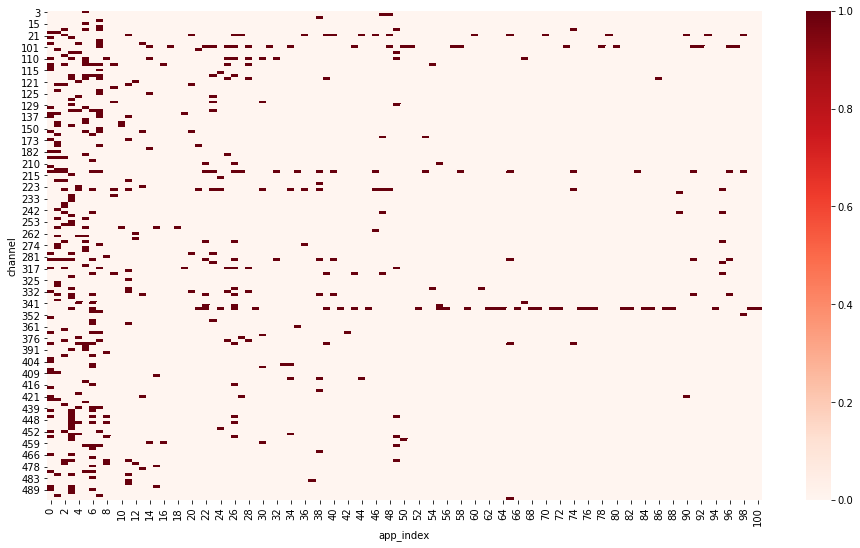

In [170]:
plt.figure(figsize=(16,9))
sns.heatmap(mat, cmap="Reds")

### クリック数上位100 app train

In [171]:
mat2 = df[(df.is_test==0)&(df.app_index <= 100)].pivot(index='channel', columns='app_index', values='flg')
mat2.fillna(0, inplace=True)


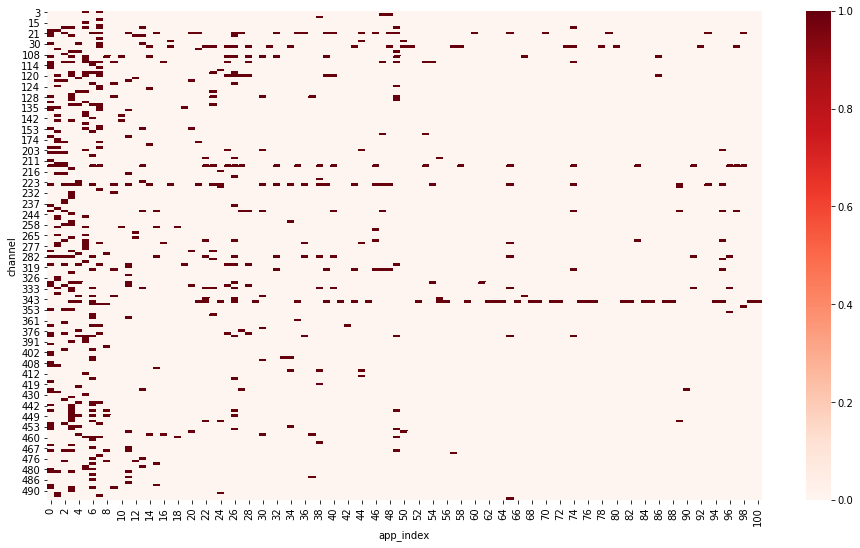

In [173]:
plt.figure(figsize=(16,9))
sns.heatmap(mat2, cmap="Reds")

<Container object of 100 artists>

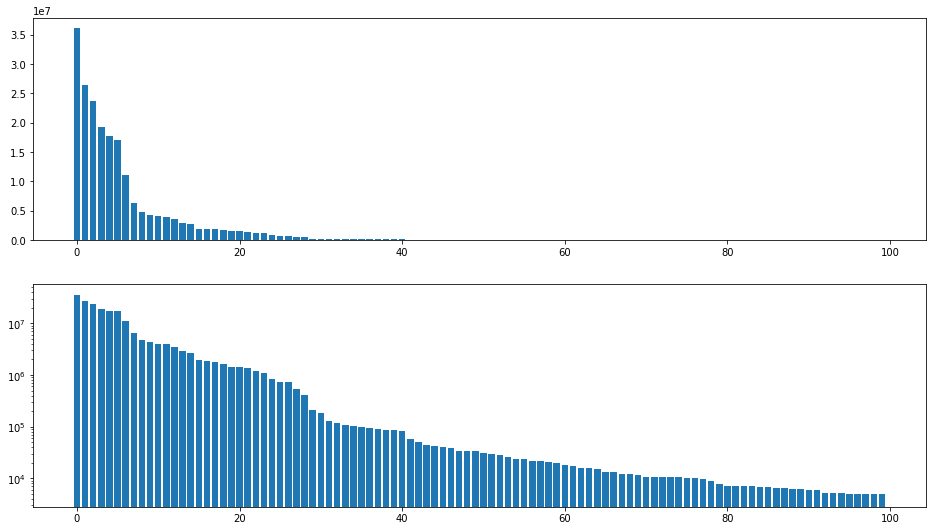

In [210]:
plt.figure(figsize=(16,9))

plt.subplot(2, 1, 1)
plt.bar(df_app[:100].index, df_app[:100].cnt)
plt.subplot(2, 1, 2)
plt.yscale('log')
plt.bar(df_app[:100].index, df_app[:100].cnt)

<Container object of 100 artists>

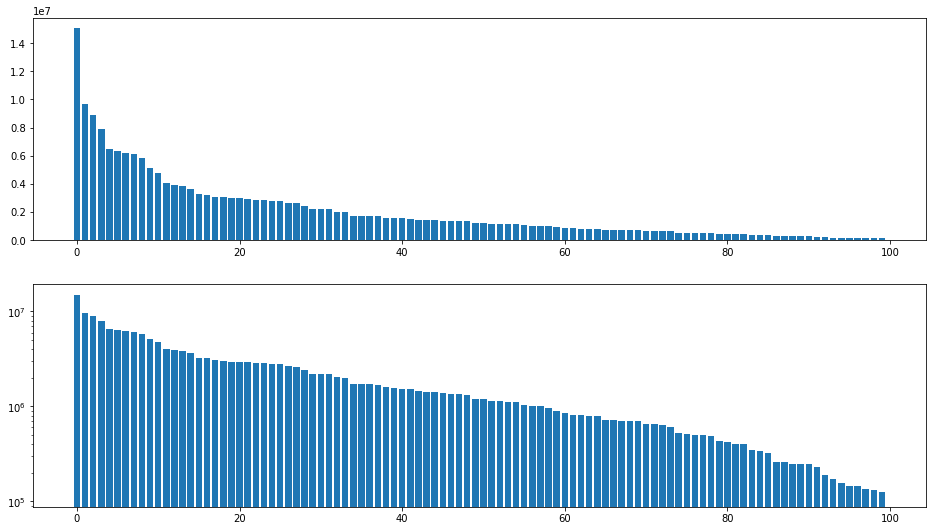

In [209]:
plt.figure(figsize=(16,9))
plt.subplot(2, 1, 1)
plt.bar(df_ch[:100].index, df_ch[:100].cnt)
plt.subplot(2, 1, 2)
plt.yscale('log')
plt.bar(df_ch[:100].index, df_ch[:100].cnt)

In [190]:
df_app_ch = df.groupby('app', as_index=False).count()[['app']]
df_app_ch['ch_cnt'] = df.groupby('app', as_index=False).count()[['channel']]
df_app_ch['clk_cnt'] = df.groupby('app', as_index=False).sum()[['cnt']]
df_app_ch.sort_values(by='ch_cnt', inplace=True, ascending=False)
df_app_ch.reset_index(inplace=True)

### app別channel数
---
click数と

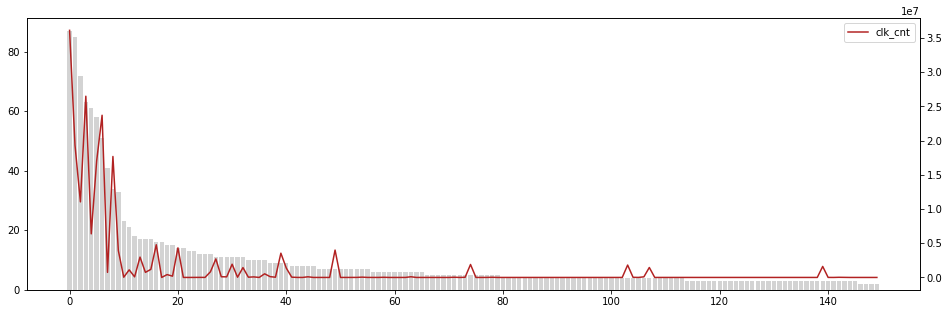

In [219]:
plt.figure(figsize=(16,5))
plt.bar(df_app_ch[:150].index, df_app_ch[:150].ch_cnt, color='lightgray')
plt.twinx()
plt.plot(df_app_ch[:150].index, df_app_ch[:150].clk_cnt, c='firebrick')
plt.legend()

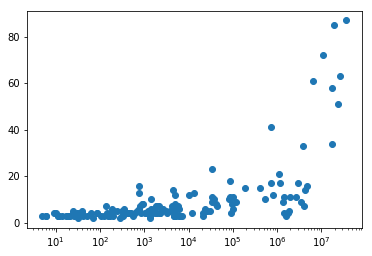

In [216]:
plt.xscale("log")
plt.scatter(df_app_ch[:150].clk_cnt, df_app_ch[:150].ch_cnt)